# Area Map 


https://scitools.org.uk/cartopy/docs/v0.5/matplotlib/introductory_examples/02.polygon.html

https://tc.copernicus.org/articles/15/4675/2021/tc-15-4675-2021.pdf

https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot

In [1]:
import glob
import cartopy 
import numpy as np 
import xarray as xr
import geopandas as gpd
import matplotlib as mpl
import contextily as ctx
import cartopy.crs as ccrs
import cartopy.geodesic as cgeo
import matplotlib.pyplot as plt 
import matplotlib.path   as mpath
import matplotlib.colors as colors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)


# Set global matplotlib style parameters
plt.rcParams.update({'text.usetex': True, 
                     'animation.html': 'jshtml', 
                     'figure.facecolor': 'w', 
                     'savefig.bbox':'tight'})

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        super().__init__(vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        # Note also that we must extrapolate beyond vmin/vmax
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1.]
        return np.ma.masked_array(np.interp(value, x, y,
                                            left=-np.inf, right=np.inf))

    def inverse(self, value):
        y, x = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.interp(value, x, y, left=-np.inf, right=np.inf)
    
    
def make_boundary(): 
    """
    https://scitools.org.uk/cartopy/docs/latest/gallery/lines_and_polygons/always_circular_stereo.html
    https://matplotlib.org/stable/api/path_api.html#matplotlib.path.Path
    """
    
    # Create vertices of for the unit circle
    theta = np.linspace(0, 2*np.pi, 201)
    center, radius = [0.0, 0.0], 1.0
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = verts * radius + center

    # extract the first quadrant from the unit circle
    quad1 = circle[:51]
    edges = (np.linspace(0.0,1.0,25) * np.array([[0],[1]])).T 
    path  = np.vstack((quad1, edges))

    # Make a path object
    boundary = mpath.Path(path)
    
    return boundary

In [2]:
RGI_IDS = [
           "01.16195",    # South      Glacier
           "01.16732",    # Glacier #12 from Crompton studies
           "01.16855",    # Glacier #18 from Crompton studies
           "01.16198-LK", # Kluane     Glacier
           "01.16198-BK", # Kluane     Glacier
           "01.16262",    # Spring     Glacier
           "01.17183",    # Klutlan    Glacier
           "01.16121",    # Tweedsmuir Glacier
           "01.16122"     # Fisher     Glacier
          ]


# legend labels dictionary
labels = ['South', 
          'Glacier 12', 
          'Glacier 18', 
          'Little Kluane', 
          'Kluane',
          'Spring',
          'Klutlan', 
          'Tweedsmuir',
          'Fisher' ]

# hex codes from colorbrewer
# ref: https://stackoverflow.com/a/47232942/10221482
colors =  plt.cm.tab20c( (4./3*np.arange(20*3/4)).astype(int) )[3:]

# File-path to RGI outlines
RGI_FP = "../../../Desktop/Big_Glaciers/Glaciers/RGI60-{}/GLIMS/RGI60-{}.shp"
flowline_fp = "../../../Desktop/Big_Glaciers/Glaciers/RGI60-{}/Manual_FL/Manual_FL-{}*.shp"

In [3]:
nc_fp = "../input_data/mass_balance/Kaskawulsh_NetBalance.nc"

with xr.open_dataset(nc_fp) as MB_new: 
    pass

midnorm = MidpointNormalize(vmin=-10., vcenter=0, vmax=5)

DriverError: ../../../Desktop/Big_Glaciers/Glaciers/RGI60-01.16195/GLIMS/RGI60-01.16195.shp: No such file or directory

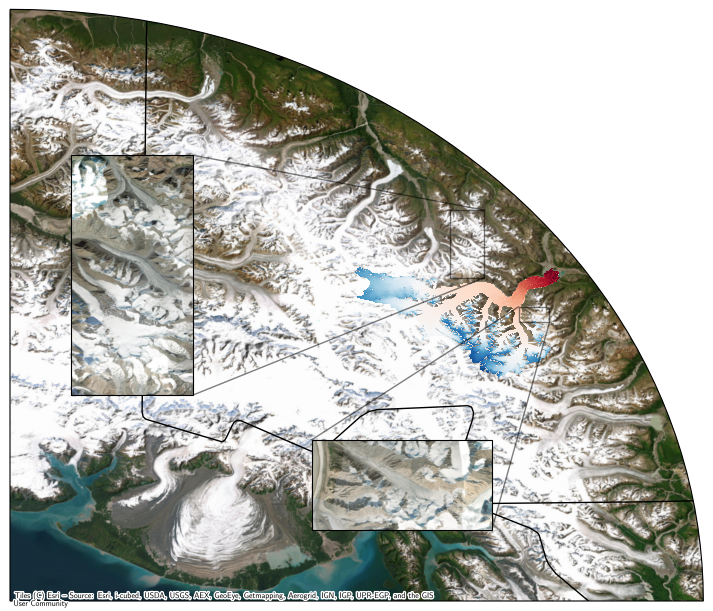

In [4]:
extent = [-141.75, -137.75, 59.65, 61.75]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# Coordinate Reference System
CRS = ccrs.AlbersEqualArea(central_lon, central_lat)
# Base image source 
source = ctx.providers.Esri.WorldImagery

province = cartopy.feature.NaturalEarthFeature(
    category="cultural", scale="50m", name="admin_1_states_provinces_lines"
)
    
fig = plt.figure(figsize=(9, 6), constrained_layout=True)
ax  = plt.axes(projection=CRS)

boundary = make_boundary()
ax.set_boundary(boundary, transform=ax.transAxes)
ax.set_extent(extent)


# ax.xaxis.set_visible(True)
# ax.yaxis.set_visible(True)
# ax.set_xlabel("Longitude")
# ax.set_ylabel("Lattitude")

# Add the base image
ctx.add_basemap(ax, 
                source=source, 
                crs=CRS.proj4_init,
                attribution_size=6 )

ax.add_feature(cartopy.feature.BORDERS, edgecolor='black')
ax.add_feature(province, linestyle="-", edgecolor="k", facecolor='None')


################################
# Inset Map!
################################
# ref: https://matplotlib.org/stable/gallery/subplots_axes_and_figures/zoom_inset_axes.html#sphx-glr-gallery-subplots-axes-and-figures-zoom-inset-axes-py
sub_ax1 = plt.axes([0.15, 0.35, 0.2, 0.4], projection=CRS)
sub_ax1.set_extent([-139.2, -139, 60.8, 61.04])

sub_ax2 = plt.axes([0.45, 0.1, 0.2, 0.2], projection=CRS)
sub_ax2.set_extent([-138.8, -138.62, 60.640, 60.694])

ax.indicate_inset_zoom(sub_ax1, edgecolor="black")
ax.indicate_inset_zoom(sub_ax2, edgecolor="black")

# Add the base image
ctx.add_basemap(sub_ax1, 
                source=source, 
                crs=CRS.proj4_init,
                attribution=False,)

ctx.add_basemap(sub_ax2, 
                source=source, 
                crs=CRS.proj4_init,
                attribution=False )

im = ax.pcolormesh(MB_new.lon, 
              MB_new.lat[::-1,:], 
              MB_new.B, 
              transform=ccrs.epsg(32607),
              cmap='RdBu', 
              norm=midnorm)

# legend enteries
patches = []

# Plot the RGI-outlines and flow
for i,rgi_id in enumerate(RGI_IDS): 
    shp_fp  = RGI_FP.format(rgi_id, rgi_id)
    shp = gpd.read_file(shp_fp)
        
    shp.to_crs(crs=CRS.proj4_init).plot(ax=ax,
                                        color=colors[i],
                                        facecolor=None,
                                        edgecolor='k',
                                        linewidth=0.5,
                                        alpha=0.5)
    
    # Manually add the legend entry 
    patches.append(mpatches.Patch(edgecolor="k", 
                                  facecolor=colors[i], 
                                  label=labels[i]))
    
    fl_fps = glob.glob(flowline_fp.format(rgi_id, rgi_id))
     
    for fl_fp in fl_fps: 
        fl = gpd.read_file(fl_fp)
        fl.to_crs(crs=CRS.proj4_init).plot(ax=ax,
                                            facecolor="None",
                                            edgecolor='k',
                                            linewidth=1.0)
                          
        # ax.add_geometries(fl.to_crs(crs=CRS.proj4_init).geometry,  
        #                   facecolor="none", 
        #                   crs=crs, 
        #                   edgecolor="k", 
        #                   linewidth=2.0)
    if rgi_id in ["01.16732", "01.16195", "01.16198-BK"]: 
        shp.to_crs(crs=CRS.proj4_init).plot(ax=sub_ax1,
                                            color=colors[i],
                                            facecolor=None,
                                            edgecolor='k',
                                            linewidth=0.5,
                                            alpha=0.5)
        for fl_fp in fl_fps: 
            fl = gpd.read_file(fl_fp)
            fl.to_crs(crs=CRS.proj4_init).plot(ax=sub_ax1,
                                                facecolor="None",
                                                edgecolor='k',
                                                linewidth=1.0)
    elif rgi_id == "01.16855": 
        shp.to_crs(crs=CRS.proj4_init).plot(ax=sub_ax2,
                                            color=colors[i],
                                            facecolor=None,
                                            edgecolor='k',
                                            linewidth=0.5,
                                            alpha=0.5)

        for fl_fp in fl_fps: 
            fl = gpd.read_file(fl_fp)
            fl.to_crs(crs=CRS.proj4_init).plot(ax=sub_ax2,
                                                facecolor="None",
                                                edgecolor='k',
                                                linewidth=1.0)
#make the legend
ax.legend(handles=patches, 
          loc="upper right", 
          ncol=1, 
          framealpha=1)

fig.colorbar(im, ax=[ax], location='left', label='Mass Balance m / yr')
fig.savefig('/Users/andrewnolan/Desktop/AreaMap.png', dpi=300, bbox_inches='tight', facecolor='w')